Generate the video of the sphere

In [36]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast
from scipy.spatial.transform import Rotation 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
import os
import subprocess

Import video

In [37]:
video_number = "5"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")
FPS = round(cap.get(cv2.CAP_PROP_FPS))

Opened: True, FPS: 30.0, Total Frames: 258.0


Import data

In [38]:
# Define the path to the CSV file
input_data_path = project_root / "notebook" / "spin" / "intermediate_data" / f"Rotation_data_processed_{video_number}.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(input_data_path)

Functions

In [39]:
def rotation_matrix(axis, theta):
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2)
    b, c, d = -axis * np.sin(theta / 2)
    return np.array([
        [a*a + b*b - c*c - d*d,     2*(b*c - a*d),     2*(b*d + a*c)],
        [2*(b*c + a*d),     a*a + c*c - b*b - d*d,     2*(c*d - a*b)],
        [2*(b*d - a*c),     2*(c*d + a*b),     a*a + d*d - b*b - c*c]
    ])

In [40]:
def align_north_pole_to_vector(target_vector):
    target_vector = target_vector / np.linalg.norm(target_vector)
    north_pole = np.array([0, 0, 1])
    
    if np.allclose(target_vector, north_pole):
        return np.eye(3)
    
    if np.allclose(target_vector, -north_pole):
        # 180 degree rotation around any perpendicular axis
        return rotation_matrix(np.array([1, 0, 0]), np.pi)
    
    axis = np.cross(north_pole, target_vector)
    angle = np.arccos(np.dot(north_pole, target_vector))
    return rotation_matrix(axis, angle)

Generate video

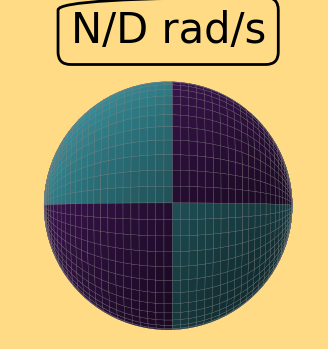

In [41]:
# Set your output path
video_output_path = project_root / "data" / f"recording_{video_number}" / "Rotating_sphere.mp4" 

# Parameters
n_frames = len(df)
angles = np.linspace(0, 2*np.pi, n_frames)

# video dimensions
# final video size is 1920x1080 -> make it 300x300 instead of 900x900
dpi = 75 # for real video 75 - for visualization 150
figure_size = 4  # for real video 4 - for visualization 6

# scaling factor for better visualization
scaling_factor = 1.5
# Sphere geometry
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
x0 = np.cos(u) * np.sin(v) * scaling_factor
y0 = np.sin(u) * np.sin(v) * scaling_factor
z0 = np.cos(v) * scaling_factor

# Create checkerboard pattern
colors = np.empty(u.shape, dtype=object)

# Number of bands of the ball (latitude and longitude)
num_lat_bands = 2
num_lon_bands = 2

# Set the color for the bands (alternating violet and light-blue)
band_colors = [(69/255, 24/255, 91/255, 1.0),  
               (57/255, 148/255, 160/255, 1.0)] 

# Assign alternating colors for latitude and longitude bands
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        lat_index = int(v[i, j] // (np.pi / num_lat_bands))  # Determine latitude band
        lon_index = int(u[i, j] // (2 * np.pi / num_lon_bands))  # Determine longitude band
        # Alternate 
        colors[i, j] = band_colors[(lat_index + lon_index) % 2]  # Alternate colors

# Initialize plot
fig = plt.figure(figsize=(figure_size, figure_size))
fig.patch.set_facecolor((255/255, 219/255, 133/255)) # Set background color to light brown
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor((255/255, 219/255, 133/255)) # Set background color to light brown
metadata = dict(title='Rotating Sphere with Axis DF')
writer = FFMpegWriter(fps=FPS, metadata=metadata)    # Set the desired FPS

first_valid_index = df['x_axis'].first_valid_index()
# print(f"First valid index where 'x_axis' is not NaN: {first_valid_index}")

last_valid_index = df['x_axis'].last_valid_index()
# print(f"Last valid index where 'x_axis' is not NaN: {last_valid_index}")

# compute the average angle to assign it whene angle is NaN
mean_angle = df['angle'].mean()

# Initialize variables
R_total = np.eye(3)
dtheta = 0
angular_velocity = np.nan

# Create and save video
with writer.saving(fig, video_output_path, dpi=dpi):
    for i, row in df.iterrows():
        ax.cla()

        # CASE: before the first valid data for the axis
        if np.isnan(row['x_axis']) and i <= first_valid_index:
            # Align sphere to the axis
            point = np.array([df.loc[first_valid_index]['x_axis'], df.loc[first_valid_index]['y_axis'], df.loc[first_valid_index]['z_axis']])
            R_align = align_north_pole_to_vector(point)
            # Apply to sphere coordinates once
            x = R_align[0, 0]*x0 + R_align[0, 1]*y0 + R_align[0, 2]*z0
            y = R_align[1, 0]*x0 + R_align[1, 1]*y0 + R_align[1, 2]*z0
            z = R_align[2, 0]*x0 + R_align[2, 1]*y0 + R_align[2, 2]*z0

            # Draw the sphere
            ax.plot_surface(x, y, z, facecolors=colors, edgecolor='gray', alpha=1, linewidth=0.2)

            ax.set_xlim([-1.2, 1.2])
            ax.set_ylim([-1.5, 0.9])
            ax.set_zlim([-1.2, 1.2])
            ax.view_init(elev=-90, azim=-90)
            ax.axis('off')

            # Draw the text
            ax.text2D(0.0, 0.09, f'N/D rad/s', ha='center', va='center', fontsize=30, color='black',
                          bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3', linewidth=2))

            writer.grab_frame()
            continue
        
        # CASE: after the last valid data for the axis
        if np.isnan(row['x_axis']) and i >= last_valid_index:
            # Align sphere to the axis
            point = np.array([df.loc[last_valid_index]['x_axis'], df.loc[last_valid_index]['y_axis'], df.loc[last_valid_index]['z_axis']])   
            R_align = align_north_pole_to_vector(point)
            # Apply to sphere coordinates once
            x = R_align[0, 0]*x0 + R_align[0, 1]*y0 + R_align[0, 2]*z0
            y = R_align[1, 0]*x0 + R_align[1, 1]*y0 + R_align[1, 2]*z0 
            z = R_align[2, 0]*x0 + R_align[2, 1]*y0 + R_align[2, 2]*z0

            # Draw the sphere
            ax.plot_surface(x, y, z, facecolors=colors, edgecolor='gray', alpha=1, linewidth=0.2)

            ax.set_xlim([-1.2, 1.2])
            ax.set_ylim([-1.5, 0.9])
            ax.set_zlim([-1.2, 1.2])
            ax.view_init(elev=-90, azim=-90)
            ax.axis('off')

            # Draw the text
            ax.text2D(0.0, 0.09, f'N/D rad/s', ha='center', va='center', fontsize=30, color='black',
                          bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3', linewidth=2))

            writer.grab_frame()
            continue
        
        # Get axis
        axis = row[['x_axis', 'y_axis', 'z_axis']].values
        
        if np.linalg.norm(axis) < 1e-6:
            continue
        
        # set new pole direction
        point = np.array([row['x_axis'], row['y_axis'], row['z_axis']])   
        R_align = align_north_pole_to_vector(point)

        # compute the new position o the sphere (rotation matrix)
        if np.isnan(row['angle']):
            # If angle is NaN, use the previous angle
            dtheta -= mean_angle
        else:
            dtheta -= row['angle'] 
        R_spin = rotation_matrix(np.array([0, 0, 1]), dtheta)
        R_total = R_align @ R_spin

        # Apply to sphere coordinates once
        x = R_total[0, 0]*x0 + R_total[0, 1]*y0 + R_total[0, 2]*z0
        y = R_total[1, 0]*x0 + R_total[1, 1]*y0 + R_total[1, 2]*z0
        z = R_total[2, 0]*x0 + R_total[2, 1]*y0 + R_total[2, 2]*z0

        # Draw the sphere
        ax.plot_surface(x, y, z, facecolors=colors, edgecolor='gray', alpha=1, linewidth=0.01)        

        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.5, 0.9])
        ax.set_zlim([-1.2, 1.2])
        ax.view_init(elev=-90, azim=-90)
        ax.axis('off')

        # Calculate angular velocity and display it
        angular_velocity = row['angle'] * FPS  

        # Display text
        if not np.isnan(angular_velocity):
            if angular_velocity > 0:
                ax.text2D(0.0, 0.09, f'{angular_velocity:.2f}rad/s ↑', ha='center', va='center', fontsize=30, color='black',
                          bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3', linewidth=2))
            else:
                ax.text2D(0.0, 0.09, f'{angular_velocity:.2f}rad/s ↓', ha='center', va='center', fontsize=30, color='black',
                          bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3', linewidth=2))
                

        writer.grab_frame()